In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm_notebook
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score,roc_curve,auc
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from sklearn.linear_model import LogisticRegression
from scipy import sparse
from prettytable import PrettyTable

In [2]:
X_train_tfidf = sparse.load_npz('X_train_tfidf_sc.npz')
X_test_tfidf = sparse.load_npz('X_test_tfidf_sc.npz')

y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

In [3]:
# finding best hyperparameters for set-1
params_tfidf = {'max_depth': [1, 5, 10, 50], 'min_samples_split': [5, 10, 100, 500]}

clf_tfidf = GridSearchCV(DecisionTreeClassifier(class_weight='balanced'), params_tfidf, scoring='roc_auc', cv=5, return_train_score=True)
clf_tfidf.fit(X_train_tfidf, y_train)

#clf.cv_results_
print(clf_tfidf.best_params_)
print(clf_tfidf.best_score_)

{'max_depth': 5, 'min_samples_split': 5}
0.6145182919704135


In [4]:
test_score_tfidf = clf_tfidf.cv_results_['mean_test_score']
train_score_tfidf = clf_tfidf.cv_results_['mean_train_score']

# https://www.kite.com/python/answers/how-to-split-a-list-into-n-parts-in-python
train_score_tfidf_hm = pd.DataFrame(np.array_split(train_score_tfidf, 4)).transpose()
test_score_tfidf_hm = pd.DataFrame(np.array_split(test_score_tfidf, 4)).transpose()

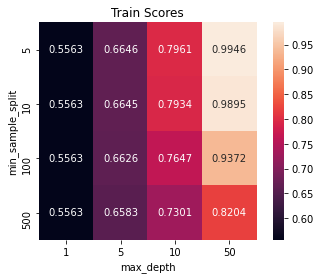

In [5]:
plt.figure()
sns.heatmap(train_score_tfidf_hm, annot=True, square=True, xticklabels=params_tfidf['max_depth'], yticklabels=params_tfidf['min_samples_split'], fmt='0.4')
plt.xlabel('max_depth')
plt.ylabel('min_sample_split')
plt.title('Train Scores')
plt.show()

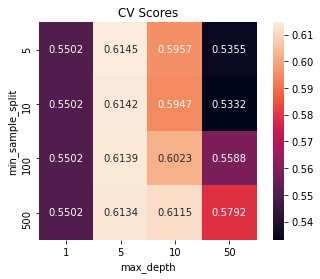

In [6]:
plt.figure()
sns.heatmap(test_score_tfidf_hm, annot=True, square=True, xticklabels=params_tfidf['max_depth'], yticklabels=params_tfidf['min_samples_split'], fmt='0.4')
plt.xlabel('max_depth')
plt.ylabel('min_sample_split')
plt.title('CV Scores')
plt.show()

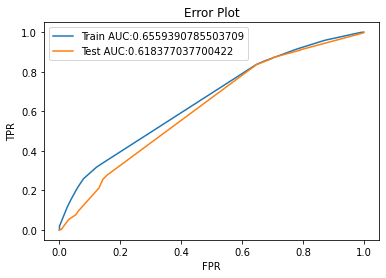

In [7]:
# training best model on best hyperparameters for set-1
best_model_tfidf = DecisionTreeClassifier(max_depth=clf_tfidf.best_params_['max_depth'], min_samples_split=clf_tfidf.best_params_['min_samples_split'], class_weight='balanced')
best_model_tfidf.fit(X_train_tfidf, y_train)

y_train_predict_tfidf = best_model_tfidf.predict_proba(X_train_tfidf)[:,1]
y_test_predict_tfidf = best_model_tfidf.predict_proba(X_test_tfidf)[:,1]

fpr1_tfidf, tpr1_tfidf, thresholds1_tfidf = roc_curve(y_train, y_train_predict_tfidf)
fpr2_tfidf, tpr2_tfidf, thresholds2_tfidf = roc_curve(y_test, y_test_predict_tfidf)

plt.figure()
plt.plot(fpr1_tfidf, tpr1_tfidf, label='Train AUC:'+str(auc(fpr1_tfidf,tpr1_tfidf)))
plt.plot(fpr2_tfidf, tpr2_tfidf, label='Test AUC:'+str(auc(fpr2_tfidf,tpr2_tfidf)))
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Error Plot')
plt.show()

In [8]:
def find_best_threshold(threshold, fpr, tpr):
    t = threshold[np.argmax(tpr*(1-fpr))]
    print('The maximum value of tpr*(1-fpr)', max(tpr*(1-fpr)), 'for threshold', np.round(t,3))
    return t

def predict_with_best_t(proba, threshold):
    predictions = []
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [9]:
best_t = find_best_threshold(thresholds1_tfidf, fpr1_tfidf, tpr1_tfidf)

print('Train confusion matrix:')
print(confusion_matrix(y_train, predict_with_best_t(y_train_predict_tfidf, best_t)))
print('Test confusion matrix:')
print(confusion_matrix(y_test, predict_with_best_t(y_test_predict_tfidf, best_t)))

The maximum value of tpr*(1-fpr) 0.2962222726828842 for threshold 0.497
Train confusion matrix:
[[ 1079  1964]
 [ 2791 14166]]
Test confusion matrix:
[[ 277  484]
 [ 750 3489]]


In [10]:
# https://stackoverflow.com/questions/61748441/how-to-fix-the-values-displayed-in-a-confusion-matrix-in-exponential-form-to-nor
def plotConfusionMatrix(matrix):
    ax = plt.subplot()
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['Rejected','Accepted'])
    ax.yaxis.set_ticklabels(['Rejected','Accepted'])

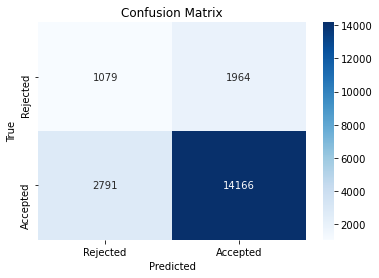

In [11]:
train_matrix = confusion_matrix(y_train, predict_with_best_t(y_train_predict_tfidf, best_t))
plotConfusionMatrix(train_matrix)

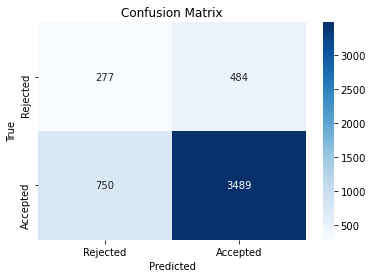

In [12]:
test_matrix = confusion_matrix(y_test, predict_with_best_t(y_test_predict_tfidf, best_t))
plotConfusionMatrix(test_matrix)

In [13]:
X_train_tfidf_w2v = sparse.load_npz('X_train_tfidf_w2v_sc.npz')
X_test_tfidf_w2v = sparse.load_npz('X_test_tfidf_w2v_sc.npz')

In [14]:
# finding best hyperparameter for set-2
params_w2v = {'max_depth': [1, 5, 10, 50], 'min_samples_split': [5, 10, 100, 500]}

clf_w2v = GridSearchCV(DecisionTreeClassifier(class_weight='balanced'), params_w2v, scoring='roc_auc', cv=5, return_train_score=True)
clf_w2v.fit(X_train_tfidf_w2v, y_train)

#clf1.cv_results_
print(clf_w2v.best_params_)
print(clf_w2v.best_score_)

{'max_depth': 5, 'min_samples_split': 5}
0.6142835961230466


In [15]:
test_score_w2v = clf_w2v.cv_results_['mean_test_score']
train_score_w2v = clf_w2v.cv_results_['mean_train_score']

# https://www.kite.com/python/answers/how-to-split-a-list-into-n-parts-in-python
train_score_hm_w2v = pd.DataFrame(np.array_split(train_score_w2v, 4)).transpose()
test_score_hm_w2v = pd.DataFrame(np.array_split(test_score_w2v, 4)).transpose()

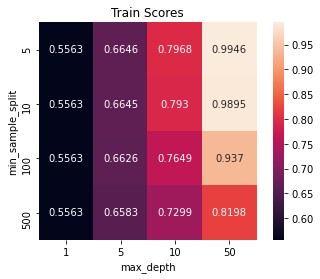

In [16]:
plt.figure()
sns.heatmap(train_score_hm_w2v, annot=True, square=True, xticklabels=params_w2v['max_depth'], yticklabels=params_w2v['min_samples_split'], fmt='0.4')
plt.xlabel('max_depth')
plt.ylabel('min_sample_split')
plt.title('Train Scores')
plt.show()

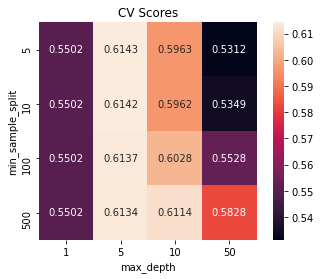

In [17]:
plt.figure()
sns.heatmap(test_score_hm_w2v, annot=True, square=True, xticklabels=params_w2v['max_depth'], yticklabels=params_w2v['min_samples_split'], fmt='0.4')
plt.xlabel('max_depth')
plt.ylabel('min_sample_split')
plt.title('CV Scores')
plt.show()

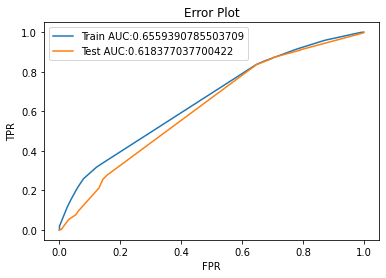

In [18]:
# training best model on best hyperparameters on set-2
best_model_w2v = DecisionTreeClassifier(max_depth=clf_w2v.best_params_['max_depth'], min_samples_split=clf_w2v.best_params_['min_samples_split'], class_weight='balanced')
best_model_w2v.fit(X_train_tfidf_w2v, y_train)

y_train_predict_w2v = best_model_w2v.predict_proba(X_train_tfidf_w2v)[:,1]
y_test_predict_w2v = best_model_w2v.predict_proba(X_test_tfidf_w2v)[:,1]

fpr1_w2v, tpr1_w2v, thresholds1_w2v = roc_curve(y_train, y_train_predict_w2v)
fpr2_w2v, tpr2_w2v, thresholds2_w2v = roc_curve(y_test, y_test_predict_w2v)

plt.figure()
plt.plot(fpr1_w2v, tpr1_w2v, label='Train AUC:'+str(auc(fpr1_w2v,tpr1_w2v)))
plt.plot(fpr2_w2v, tpr2_w2v, label='Test AUC:'+str(auc(fpr2_w2v,tpr2_w2v)))
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Error Plot')
plt.show()

In [19]:
best_t = find_best_threshold(thresholds1_w2v, fpr1_w2v, tpr1_w2v)

print('Train confusion matrix:')
print(confusion_matrix(y_train, predict_with_best_t(y_train_predict_w2v, best_t)))
print('Test confusion matrix:')
print(confusion_matrix(y_test, predict_with_best_t(y_test_predict_w2v, best_t)))

The maximum value of tpr*(1-fpr) 0.2962222726828842 for threshold 0.497
Train confusion matrix:
[[ 1079  1964]
 [ 2791 14166]]
Test confusion matrix:
[[ 277  484]
 [ 750 3489]]


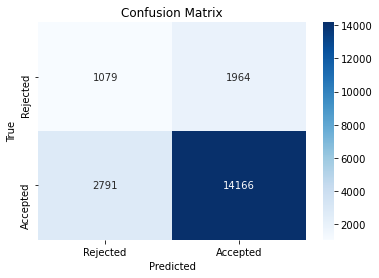

In [20]:
train_matrix = confusion_matrix(y_train, predict_with_best_t(y_train_predict_w2v, best_t))
plotConfusionMatrix(train_matrix)

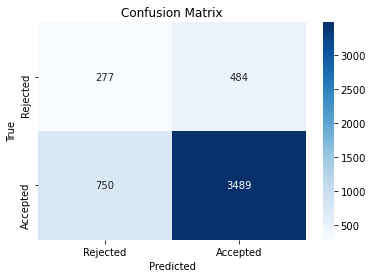

In [21]:
test_matrix = confusion_matrix(y_test, predict_with_best_t(y_test_predict_w2v, best_t))
plotConfusionMatrix(test_matrix)

In [22]:
table = PrettyTable()
table.field_names=('Vectorizer', 'Hyper-Parameter', 'AUC')
table.add_row(['TFIDF', str('Depth: ' + str(clf_tfidf.best_params_['max_depth']) + ' Split: ' +str(clf_tfidf.best_params_['min_samples_split'])), auc(fpr2_tfidf,tpr2_tfidf)])
table.add_row(['TFIDF_W2V', str('Depth: ' + str(clf_w2v.best_params_['max_depth']) + ' Split: ' +str(clf_w2v.best_params_['min_samples_split'])), auc(fpr2_w2v,tpr2_w2v)])
print(table)

+------------+-------------------+-------------------+
| Vectorizer |  Hyper-Parameter  |        AUC        |
+------------+-------------------+-------------------+
|   TFIDF    | Depth: 5 Split: 5 | 0.618377037700422 |
| TFIDF_W2V  | Depth: 5 Split: 5 | 0.618377037700422 |
+------------+-------------------+-------------------+
